<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Carolina Flores Luelmo y Claudia Estefanía Meza Fonseca

**Fecha:** 21 de octubre del 2021.
    
**Expediente** : Carolina: 713578. Estefanía: 729930
    
**Profesor:** Oscar David Jaramillo Zuluaga.

**Liga GitHub:** https://github.com/Carofl6/Tarea7_CFlores_FHernandez

# Tarea 9
    

# Tarea

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
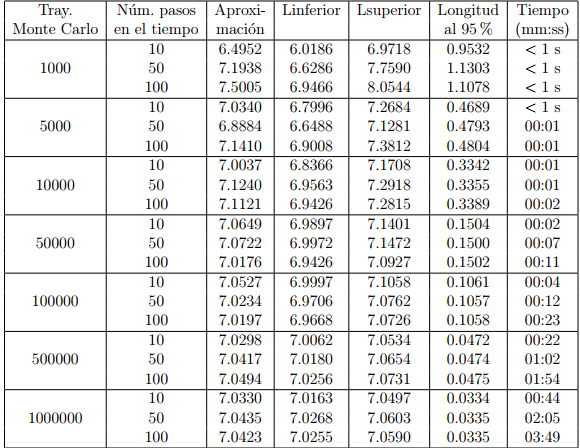

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

## Solución estudiante 1:


## Solución estudiante 2: Claudia Estefanía Meza Fonseca


$$\textbf{Valor call asiático}\longrightarrow V_0(K)=e^{-rT}E\Bigg[ \Big({1\over T} \int_0^T S_u du -K\Big)_+\Bigg]$$ 

Sumas de Rieman:
$$\hat V_0^{(1)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({1\over N} \sum_{i=0}^{N-1} S_{t_i}-K \Bigg)_+$$

Trapecios:
$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$
**recordar que $h = \frac{T}{N}$**

In [8]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [3]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [4]:
#Función donde se almacenan todos los resultados del método de esquema de trapecios
def Metodo_trapecio_valopt(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    tipo:"Tipo de opción: 'put' o 'call' recibe el string, default tipo call"=None):
    """ Está función devuelve la valuación, el limite inferior, superior y la longitud al 95% de confianza, además
    del tiempo que se tardó en correr todo el proceso para opciones de tipo put o call de acuerdo a la que requiera
    el usuario de acuerdo con el método de esquema de trapecios"""
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    # En este caso se  define un h que se requiere para la fórmula del trapecio
    h = T/NbStep
    Average_t = np.cumsum(prices *
                          (2+r*h+np.random.randn(NbStep,NbTraj)*sigma))*h/(2*T)
    # Definimos el dataframe de strikes
    strike = K
    # Se valua la prima de acuerdo al tipo de opción: call o put
    if tipo == 'call':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    elif tipo == 'put':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    else:
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = val_opt.sem().Prima
    mean_est = val_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    dif95 = np.round(i1[1] - i1[0],4)
    end = time.time()
    e = int(end - start)
    time_format = '{:02d}:{:02d}'.format((e % 3600 // 60), e % 60)
    invested_time = lambda x: '< 1 s' if x == '00:00' else x
    return np.array([np.round(val_opt.iloc[-1].Prima,4),np.round(i1[0],4),np.round(i1[1],4),dif95,
                     invested_time(time_format)])

In [5]:
# Función donde se almacenan todos los resultados del método de sumas de riemann
def Riemann_approach(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',
                    tipo:"Tipo de opción: 'put' o 'call' recibe el string, default tipo call"=None):
    """ Está función devuelve la valuación, el limite inferior, superior y la longitud al 95% de confianza, además
    del tiempo que se tardó en correr todo el proceso para opciones de tipo put o call de acuerdo a la que requiera
    el usuario de acuerdo con el método de riemann"""
    start = time.time()
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = K
    # # Se valua la prima de acuerdo al tipo de opción: call o put
    if tipo == 'call':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    elif tipo == 'put':
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(strike - Average_t, 0).mean(axis=1)}, index=t)
    else:
        val_opt = pd.DataFrame({'Prima': np.exp(-r*T) \
                     *np.fmax(Average_t - strike, 0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = val_opt.sem().Prima
    mean_est = val_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    dif95 = np.round(i1[1] - i1[0],4)
    end = time.time()
    e = int(end - start)
    time_format = '{:02d}:{:02d}'.format((e % 3600 // 60), e % 60)
    invested_time = lambda x: '< 1 s' if x == '00:00' else x
    return np.array([np.round(val_opt.iloc[-1].Prima,4),np.round(i1[0],4),np.round(i1[1],4),dif95,
                     invested_time(time_format)])

Se definen los datos que brinda el problema para valuar las opciones con los dos métdos.

In [6]:
S0 = 100 #Strike price
r = 0.10 #Tasa libre de riesgo
sigma = 0.2 
K = 100 #Strike
T=1 #Tiempo en años
NbTraj = [1000,5000,10000,50000,100000,500000,1000000] #Número de trayectorias
NbStep = [10,50,100] #Número de pasos

### Opción call esquema trapecios

In [9]:
#Se genera la simulación para el tipo call
call =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                              Metodo_trapecio_valopt(K,r,S0,N_traj,N_step,sigma,T,'call'),NbStep)),NbTraj)))

In [10]:
##Tabla de simulaciones para el tipo call
pd.set_option("display.max_rows", None, "display.max_columns", None)#Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]#Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: call[:,:,i].flatten(),range(5))))# Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]#Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))#Se genera el multiIndex
call_df = pd.DataFrame(index=index)#Se convierte a DataFrame el MultiIndex
call_df

Empty DataFrame
Columns: []
Index: [(1000, 10, 7.1226, 5.7259, 8.5193, 2.7934, < 1 s), (1000, 50, 7.2095, 6.7796, 7.6394, 0.8597, < 1 s), (1000, 100, 7.4294, 7.1376, 7.7213, 0.5837, < 1 s), (5000, 10, 6.8148, 5.479, 8.1505, 2.6714, < 1 s), (5000, 50, 7.1532, 6.7299, 7.5764, 0.8465, < 1 s), (5000, 100, 7.1529, 6.8713, 7.4345, 0.5632, < 1 s), (10000, 10, 6.8973, 5.5443, 8.2502, 2.7059, < 1 s), (10000, 50, 7.1447, 6.7223, 7.567, 0.8447, < 1 s), (10000, 100, 7.0714, 6.793, 7.3498, 0.5569, < 1 s), (50000, 10, 6.9132, 5.5571, 8.2694, 2.7123, < 1 s), (50000, 50, 7.0396, 6.6236, 7.4556, 0.832, < 1 s), (50000, 100, 7.0644, 6.7862, 7.3425, 0.5563, < 1 s), (100000, 10, 6.8763, 5.5278, 8.2249, 2.697, < 1 s), (100000, 50, 7.0245, 6.6099, 7.4391, 0.8292, < 1 s), (100000, 100, 7.0418, 6.7648, 7.3187, 0.5539, 00:02), (500000, 10, 6.9092, 5.5542, 8.2642, 2.7101, < 1 s), (500000, 50, 7.0036, 6.59, 7.4173, 0.8272, 00:05), (500000, 100, 7.0365, 6.7597, 7.3133, 0.5536, 00:15), (1000000, 10, 6.897, 5.5444, 8.2497, 2.7053, 00:01), (1000000, 50, 7.0209, 6.6063, 7.4355, 0.8292, 00:11), (1000000, 100, 7.026, 6.7498, 7.3023, 0.5525, 00:26)]

### Opción call método Riemann

In [11]:
#Se genera la simulación para el tipo call
call =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                              Riemann_approach(K,r,S0,N_traj,N_step,sigma,T,'call'),NbStep)),NbTraj)))

In [12]:
#Se genera la tabla de simulaciones para el tipo call
pd.set_option("display.max_rows", None, "display.max_columns", None)#Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]#Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: call[:,:,i].flatten(),range(5))))# Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,np.round(results[0].astype('float'),4),results[1],results[2],results[3],results[4]]#Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))#Se genera el multiIndex
call_df2 = pd.DataFrame(index=index)
call_df2

Empty DataFrame
Columns: []
Index: [(1000, 10, 5.8923, 4.7251, 7.0596, 2.3345, < 1 s), (1000, 50, 6.8757, 6.3548, 7.3967, 1.0419, < 1 s), (1000, 100, 6.6945, 6.3491, 7.0399, 0.6908, < 1 s), (5000, 10, 6.4776, 5.1956, 7.7596, 2.564, < 1 s), (5000, 50, 7.0127, 6.4889, 7.5366, 1.0478, < 1 s), (5000, 100, 6.8594, 6.5075, 7.2113, 0.7038, < 1 s), (10000, 10, 6.4018, 5.1344, 7.6692, 2.5348, < 1 s), (10000, 50, 6.8397, 6.3284, 7.351, 1.0226, < 1 s), (10000, 100, 6.9229, 6.568, 7.2778, 0.7098, < 1 s), (50000, 10, 6.4036, 5.1349, 7.6723, 2.5374, 00:01), (50000, 50, 6.8602, 6.3487, 7.3717, 1.023, 00:02), (50000, 100, 6.9548, 6.5972, 7.3124, 0.7152, 00:02), (100000, 10, 6.4211, 5.1495, 7.6927, 2.5432, 00:04), (100000, 50, 6.9433, 6.4241, 7.4625, 1.0384, 00:04), (100000, 100, 6.9687, 6.609, 7.3284, 0.7194, 00:04), (500000, 10, 6.411, 5.1402, 7.6818, 2.5416, 00:19), (500000, 50, 6.9207, 6.4041, 7.4372, 1.033, 00:23), (500000, 100, 6.9979, 6.6372, 7.3587, 0.7215, 00:23), (1000000, 10, 6.4213, 5.1481, 7.6945, 2.5465, 00:34), (1000000, 50, 6.9152, 6.3991, 7.4313, 1.0321, 00:38), (1000000, 100, 6.9887, 6.6285, 7.3489, 0.7204, 00:56)]

Como queremos acercarnos a que el precio sea aproximadamente 7.04 con el método de trapecios en menos tiempo y menos simulaciones logramos aproximarnos más. Y con el método de riemann podemos ver que se aproxima pero se tarda más y requiere de más trayectorias para aproximarnos al valor que queremos. En conlusión es mejor a mi parecer el método de esquema de trapecios.

### Opción put esquema trapecios

In [13]:
#Simulación para el tipo put
put =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                              Metodo_trapecio_valopt(K,r,S0,N_traj,N_step,sigma,T,'put'),NbStep)),NbTraj)))

In [14]:
#Se genera la tabla de simulaciones para el tipo put
pd.set_option("display.max_rows", None, "display.max_columns", None)###Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]###Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: put[:,:,i].flatten(),range(5))))### Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]###Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))###Se genera el multiIndex
put_df = pd.DataFrame(index=index)###Se convierte a DataFrame el MultiIndex
put_df

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.1426, -15.007, 19.2922, 34.2992, < 1 s), (1000, 50, 2.4905, -4.9544, 9.9353, 14.8897, < 1 s), (1000, 100, 2.2812, -2.9806, 7.543, 10.5236, < 1 s), (5000, 10, 2.2475, -14.8564, 19.3514, 34.2077, < 1 s), (5000, 50, 2.2609, -5.204, 9.7259, 14.9299, < 1 s), (5000, 100, 2.3429, -2.9209, 7.6066, 10.5275, < 1 s), (10000, 10, 2.2595, -14.8424, 19.3614, 34.2038, < 1 s), (10000, 50, 2.2716, -5.1991, 9.7422, 14.9414, < 1 s), (10000, 100, 2.3496, -2.9078, 7.607, 10.5148, < 1 s), (50000, 10, 2.2121, -14.9084, 19.3327, 34.2411, < 1 s), (50000, 50, 2.3554, -5.1042, 9.815, 14.9192, < 1 s), (50000, 100, 2.3267, -2.9319, 7.5852, 10.5171, < 1 s), (100000, 10, 2.2205, -14.8975, 19.3385, 34.236, < 1 s), (100000, 50, 2.3197, -5.1455, 9.7848, 14.9303, < 1 s), (100000, 100, 2.3294, -2.9291, 7.5879, 10.517, 00:02), (500000, 10, 2.2301, -14.8871, 19.3472, 34.2343, < 1 s), (500000, 50, 2.3434, -5.1165, 9.8033, 14.9198, 00:05), (500000, 100, 2.3471, -2.9104, 7.6047, 10.5151, 00:11), (1000000, 10, 2.2224, -14.8953, 19.3401, 34.2354, 00:02), (1000000, 50, 2.337, -5.125, 9.799, 14.924, 00:13), (1000000, 100, 2.3472, -2.9102, 7.6045, 10.5147, 00:38)]

### Opción put método Riemann

In [15]:
#simulación para el tipo put
put =  np.array(list(map(lambda N_traj:list(map(lambda N_step:
                                             Riemann_approach(K,r,S0,N_traj,N_step,sigma,T,'put'),NbStep)),NbTraj)))

In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)###Permite que se visualice toda la tabla en el jupyter
NbTrajidx =[i for i in NbTraj for _ in (0, 1, 2)]###Se genera un indice para las trayectorias
results = np.array(list(map(lambda i: put[:,:,i].flatten(),range(5))))### Se separan los resultados 
arrays = [NbTrajidx,NbStep*7,results[0],results[1],results[2],results[3],results[4]]###Se agregan los resultados a los indices
index = pd.MultiIndex.from_arrays(arrays, names=('Tray. Monte Carlo', 'Núm. pasos en el tiempo','Aproximación','Linferior'
                                                ,'Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))###Se genera el multiIndex
put_df2 = pd.DataFrame(index=index)###Se convierte a DataFrame el MultiIndex
put_df2

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.3693, 1.9141, 2.8245, 0.9104, < 1 s), (1000, 50, 2.2667, 2.121, 2.4124, 0.2913, < 1 s), (1000, 100, 2.3676, 2.2649, 2.4704, 0.2055, < 1 s), (5000, 10, 2.2335, 1.8005, 2.6664, 0.8659, < 1 s), (5000, 50, 2.2663, 2.1236, 2.409, 0.2855, < 1 s), (5000, 100, 2.3467, 2.247, 2.4465, 0.1995, < 1 s), (10000, 10, 2.2379, 1.8109, 2.665, 0.8542, < 1 s), (10000, 50, 2.3457, 2.1967, 2.4948, 0.2981, < 1 s), (10000, 100, 2.2911, 2.1948, 2.3873, 0.1925, < 1 s), (50000, 10, 2.2268, 1.8008, 2.6528, 0.852, 00:02), (50000, 50, 2.3459, 2.1966, 2.4953, 0.2987, 00:02), (50000, 100, 2.3541, 2.2535, 2.4547, 0.2012, 00:02), (100000, 10, 2.2087, 1.7859, 2.6316, 0.8457, 00:03), (100000, 50, 2.3264, 2.1789, 2.4738, 0.2949, 00:04), (100000, 100, 2.3489, 2.2489, 2.4489, 0.2, 00:04), (500000, 10, 2.2247, 1.7984, 2.6509, 0.8525, 00:17), (500000, 50, 2.334, 2.186, 2.4819, 0.2958, 00:21), (500000, 100, 2.3455, 2.2459, 2.4451, 0.1992, 00:23), (1000000, 10, 2.2215, 1.7956, 2.6474, 0.8518, 00:39), (1000000, 50, 2.3402, 2.1916, 2.4887, 0.2971, 00:46), (1000000, 100, 2.3502, 2.2502, 2.4502, 0.2, 00:45)]

En este caso, ambos métodos de aproximación arrojan resultados muy similares para la opción de venta asiática. Los dos muestran una prima de aproximadamente 2.34. Sin embargo, es posible ver que la simulación de Montecarlo con las Sumas de Riemann siguió tardando más que con el Esquema del Trapecio. 

###  Conclusiones:
En términos generales, tanto para el put como para el call asiático, el método de valuación del Esquema del Trapecio resultó ser más preciso y menos tardado que el de las Sumas de Riemann. Sin embargo, se observó que en las opciones de venta, el Esquema del Trapecio arrojó longitudes del intervalo de confianza muy altas.